# Pipeline Suitability Analysis

This notebook demonstrates the workflow for finding optimal pipeline paths using geospatial suitability analysis. The analysis consists of:

1. Loading raster factors and reference paths
2. Creating cost maps with weighted factors
3. Finding least cost paths between points
4. Comparing predicted paths with reference paths
5. Optimizing weights

## Setup and Import Libraries

In [3]:
import psutil
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available RAM: 0.83 GB


In [1]:
# Import required libraries
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# Import our custom pipeline analysis modules
from pipefit.data_loader import DataLoader, load_reference_path
from pipefit.cost_map import CostMapGenerator
from pipefit.path_finder import LeastCostPathFinder
from pipefit.path_evaluator import PathEvaluator

## 1. Load Dataset

First, we'll load a dataset containing raster factors and reference path.

In [3]:
# Set the path to your dataset folder
dataset_path = 'datasets/roi1_600k_300k_meters'#'datasets/interest_area_500scale'#"datasets/roi1_600k_300k_meters"#"datasets/vankor_1k_1k_pixel"#"datasets/roi1_600k_300k_meters"

# Define a factor mapping (optional)
factor_mapping = {
    # Map filename to standardized name      
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

# Create a data loader and load the data
data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)

# Load reference path separately
reference_path_dir = os.path.join(dataset_path, 'reference')
reference_path = load_reference_path(reference_path_dir)

Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/roi1_600k_300k_meters\reference\roi1_path.geojson


### For presentation - построенный маршрут основная информация

In [13]:
import geopandas as gpd

gdf = gpd.read_file(r'datasets/roi2_100scale/results/least_cost_path_roi2.geojson')#(r'C:\Users\user\pipefit\pipefit\datasets\roi1_100scale\results\least_cost_path_roi1.geojson')
print(gdf.crs) 

EPSG:3857


In [14]:
# Проверка типа геометрии (должна быть LineString или MultiLineString)
print("Тип геометрии:", gdf.geometry.type)

# Расчет длины для каждого объекта в файле
gdf['length'] = gdf.geometry.length  # Длина в единицах проекции (обычно метры)

# Вывод результатов
print(gdf[['length']].head())

# Суммарная длина всех сегментов (если маршрут состоит из нескольких частей)
total_length = gdf['length'].sum()
print(f"\nОбщая длина маршрута: {total_length:.2f} метров")

Тип геометрии: 0    LineString
dtype: object
         length
0  1.985159e+06

Общая длина маршрута: 1985158.61 метров


In [15]:
line = gdf.geometry.iloc[0]  # Берем первую геометрию
print(f"Длина маршрута: {line.length:.2f} метров")

Длина маршрута: 1985158.61 метров


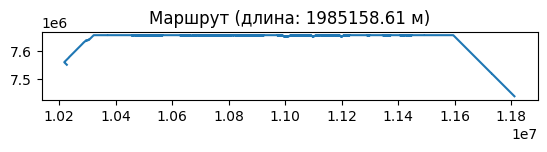

In [16]:
import matplotlib.pyplot as plt

# Простая визуализация
gdf.plot()
plt.title(f"Маршрут (длина: {total_length:.2f} м)")
plt.show()

## 2. Visualize Input Factors

Let's examine the normalized raster factors that we'll use to create the cost map.

In [4]:
# Create a cost map generator
cost_generator = CostMapGenerator(data_loader.factors)

In [5]:
#data_loader.factors

In [6]:
#min(np.min(data_loader.factors[factor_name]) for factor_name in data_loader.factors)

Визуализация для презентации

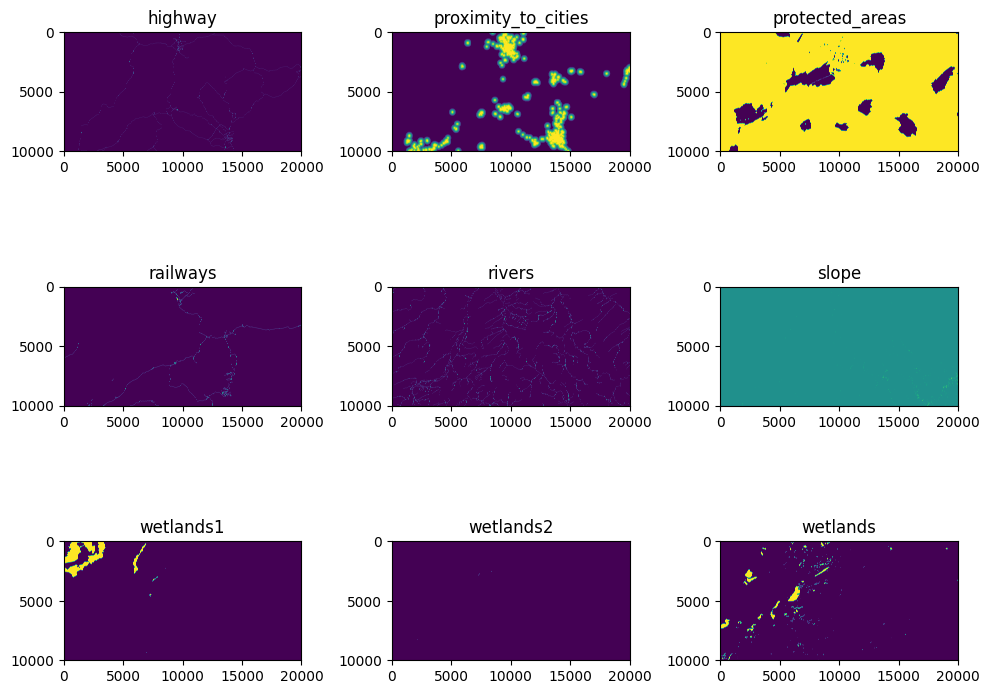

In [6]:
factors_to_show = [factor_name for factor_name in data_loader.factors]

num_factors = len(factors_to_show)
cols = min(num_factors, 3)
rows = (num_factors + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

if num_factors == 1:
    axes = np.array([axes])

axes = axes.flatten()

# Create a single colorbar for all plots
vmin = min(np.min(data_loader.factors[factor_name]) for factor_name in factors_to_show)
vmax = max(np.max(data_loader.factors[factor_name]) for factor_name in factors_to_show)

for i, factor_name in enumerate(factors_to_show):
    ax = axes[i]
    im = ax.imshow(data_loader.factors[factor_name], cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(factor_name)
    
# Add a single colorbar for all subplots
#fig.colorbar(im, ax=axes.tolist(), shrink=0.6, pad=1)
    
# Hide unused subplots
for i in range(num_factors, len(axes)):
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

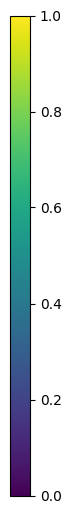

In [4]:
cbar_fig = plt.figure(figsize=(1, 6))
cbar_ax = cbar_fig.add_axes([0.1, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cbar_ax)
#cbar.set_label('Значения шкалы')

plt.show()

In [2]:
from prettytable import PrettyTable

weights = {
   #'protected_areas': '?',
    'highway': '0.6'#?',   
    # 'proximity_to_cities': '?', 
    # 'slope': '?',
    # 'railways': '?',          
    # 'rivers': '?',        
    # 'wetlands': '?',
    # 'wetlands1': '?',
    # 'wetlands2': '?',      
}

# weights = {
#    #'protected_areas': 1,
#     'highway': 0.6,   
#     'proximity_to_cities': 1, 
#     'slope': 1,
#     'railways': 0.6,          
#     'rivers': 0.7,        
#     'wetlands': 0.7,
#     'wetlands1': 0.5,
#     'wetlands2': 0.9,      
# }

# Создаем таблицу
table = PrettyTable()

# Настраиваем столбцы
table.field_names = ["Фактор", "Вес"]
table.align["Фактор"] = "l"  # Выравнивание по левому краю
table.align["Вес"] = "r"     # Выравнивание по правому краю
table.float_format = ".1"     # Формат чисел с одним десятичным знаком

# Добавляем данные
for factor, weight in weights.items():
    table.add_row([factor, weight])

# Выводим таблицу
print(table)

+---------+-----+
| Фактор  | Вес |
+---------+-----+
| highway | 0.6 |
+---------+-----+


In [ ]:
# Visualize all input factors
#cost_generator.visualize_factors(figsize=(15, 10))

## 3. Generate Cost Map

Now we'll create a cost map by combining factors with weights. The weights reflect the relative importance of each factor in determining pipeline suitability.

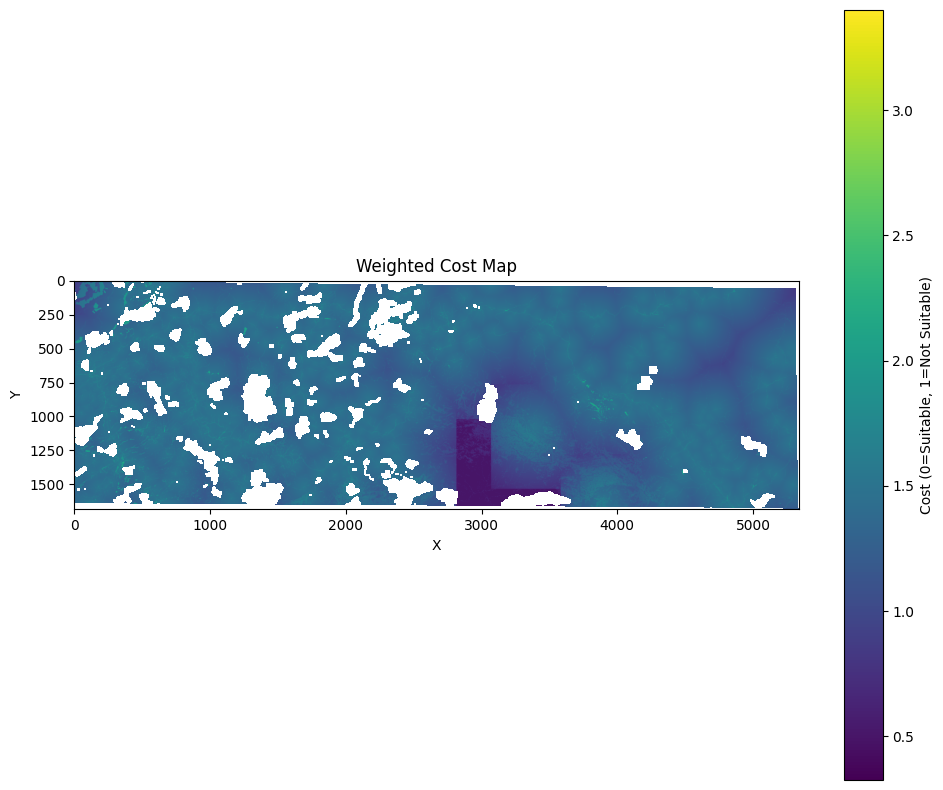

Saved raster to datasets/interest_area_500scale\results\cost_map.tif


In [ ]:
# Define weights for each factor
# These can be different from the factor names in the data files
weights = {
#    'protected_areas': 1,
    'highway': 0.6,   
    'proximity_to_cities': 1, 
    'slope': 1,
    'railways': 0.6,          
    'rivers': 0.7,        
    'wetlands': 0.7,
    'wetlands1': 0.5,
    'wetlands2': 0.9,      
}

# # Optional: Define a weight-to-factor mapping if your weight keys don't match factor names
weight_mapping = None  # We're using standardized names, so no mapping needed

# Generate cost map with default weight for any missing factors
cost_map = cost_generator.generate_cost_map(
    weights=weights,
    default_weight=1,  # Any factors without explicit weights get this value
    weight_mapping=weight_mapping
)

# Replace 0 to inf
cost_map[cost_map == 0] = np.inf

# Visualize cost map
cost_generator.visualize_cost_map(cost_map, title="Weighted Cost Map")

# Save cost map (optional)
cost_map_path = os.path.join(dataset_path, 'results', 'cost_map.tif')
os.makedirs(os.path.dirname(cost_map_path), exist_ok=True)
data_loader.save_raster(cost_map, cost_map_path)

In [8]:
# cost_map.min()

## 4. Find Least Cost Path

Using the cost map, we'll find the least cost path between start and end points.

Start point: (641, 11), End point: (1628, 4813)
Path found with total cost: 6547.149763733345


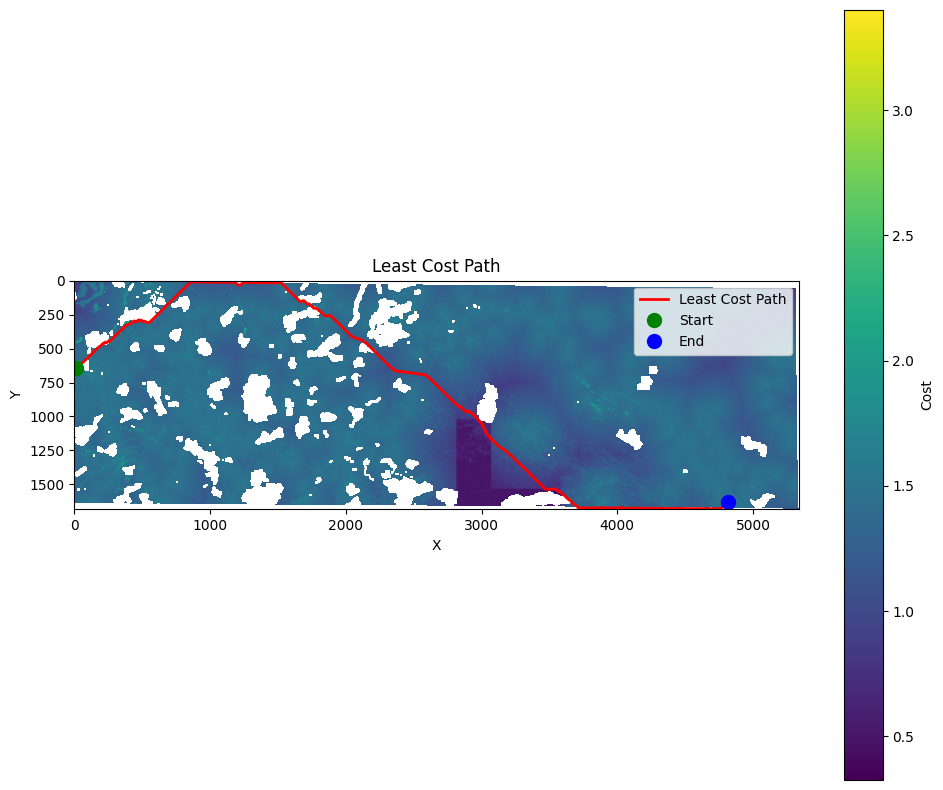

In [64]:
# Define start and end points
# Option 1: Define using geographical coordinates


# start_x, start_y = 9187144, 7397263#8536880, 9502543  # Example coordinates (replace with actual coordinates)
# end_x, end_y = 9767670, 7597333 #8563026, 9496811 #8832995, 9632587     # Example coordinates (replace with actual coordinates) 8831023, 9630540


start_x, start_y = 9167986, 7388294 # 8536880, 9502543 - для ванкора
end_x, end_y = 11568914, 6894631 # 8563026, 9496811- для ванкора

# # Convert to raster indices
start_indices = data_loader.coordinates_to_indices(start_x, start_y)
end_indices = data_loader.coordinates_to_indices(end_x, end_y)

# Option 2: Define directly as raster indices
#start_indices = (12000, 100)   # Example indices (row, col) (replace with actual indices) (5381, 0) to (0, 10925)
#end_indices = (10000, 2500)    # Example indices (row, col) (replace with actual indices) -на границе падало ядро

# Option 3: Use default start/end points (lower left to upper right)
#start_indices = None # None Will use lower left corner
#end_indices = None    # Will use upper right corner

print(f"Start point: {start_indices}, End point: {end_indices}")

# Create path finder (no need to pass transform/crs at initialization)
path_finder = LeastCostPathFinder(cost_map)

# Get metadata for later use
metadata = data_loader.get_common_metadata()

# Find least cost path using A* algorithm (default)
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  # 'astar' or 'dijkstra'
    fully_connected=True  # Use 8-connected neighbors
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

## 5. Compare with Reference Path

Now we'll compare our predicted path with the reference (ground truth) path and calculate similarity metrics.

In [ ]:
#pip install geopandas shapely

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Участок трубы раздроблен

In [46]:
import geopandas as gpd
from shapely import LineString, Point, ops
import numpy as np

def sort_linestrings(lines):
    if not lines:
        return []

    # Делаем копию
    lines = [line for line in lines]
    sorted_lines = [lines.pop(0)]

    while lines:
        last_line = sorted_lines[-1]
        last_point = Point(last_line.coords[-1])

        distances = []
        for i, line in enumerate(lines):
            start = Point(line.coords[0])
            end = Point(line.coords[-1])
            dist_start = last_point.distance(start)
            dist_end = last_point.distance(end)
            distances.append((i, dist_start, dist_end, line))

        # Выбираем минимальное из двух возможных
        closest = min(distances, key=lambda x: min(x[1], x[2]))
        idx, dist_start, dist_end, next_line = closest

        # Переворачиваем, если ближе конец
        if dist_end < dist_start:
            next_line = LineString(list(next_line.coords)[::-1])

        sorted_lines.append(next_line)
        lines.pop(idx)

    return sorted_lines


# Загружаем данные из файла
input_file = r"datasets\interest_area_500scale\reference\single_parts_omsk_pipe.geojson"
output_file = r"datasets\interest_area_500scale\reference\ordered_pipeline2.geojson"

try:
    gdf = gpd.read_file(input_file)
except Exception as e:
    raise Exception(f"Ошибка при чтении файла: {e}")

# Получаем все LineStrings
lines = [feature.geometry for _, feature in gdf.iterrows()]

# Сортируем линии по пространству
sorted_lines = sort_linestrings(lines)

# Объединяем в одну LINESTRING
try:
    merged_line = ops.linemerge(sorted_lines)
except Exception as e:
    print("Не удалось объединить в LineString:", e)
    merged_line = LineString([p for line in sorted_lines for p in line.coords])

# Создаём новый GeoDataFrame
result_gdf = gpd.GeoDataFrame(
    {"name": ["Ordered Pipeline"]},
    geometry=[merged_line],
    crs=gdf.crs
)

# Сохраняем в GeoJSON
result_gdf.to_file(output_file, driver="GeoJSON")
print(f"✅ Готово! Результат сохранён в '{output_file}'")

✅ Готово! Результат сохранён в 'datasets\interest_area_500scale\reference\ordered_pipeline2.geojson'


In [58]:
result_gdf

,name,geometry
0,Ordered Pipeline,"MULTILINESTRING ((9162262.42 7389587.333, 9162..."


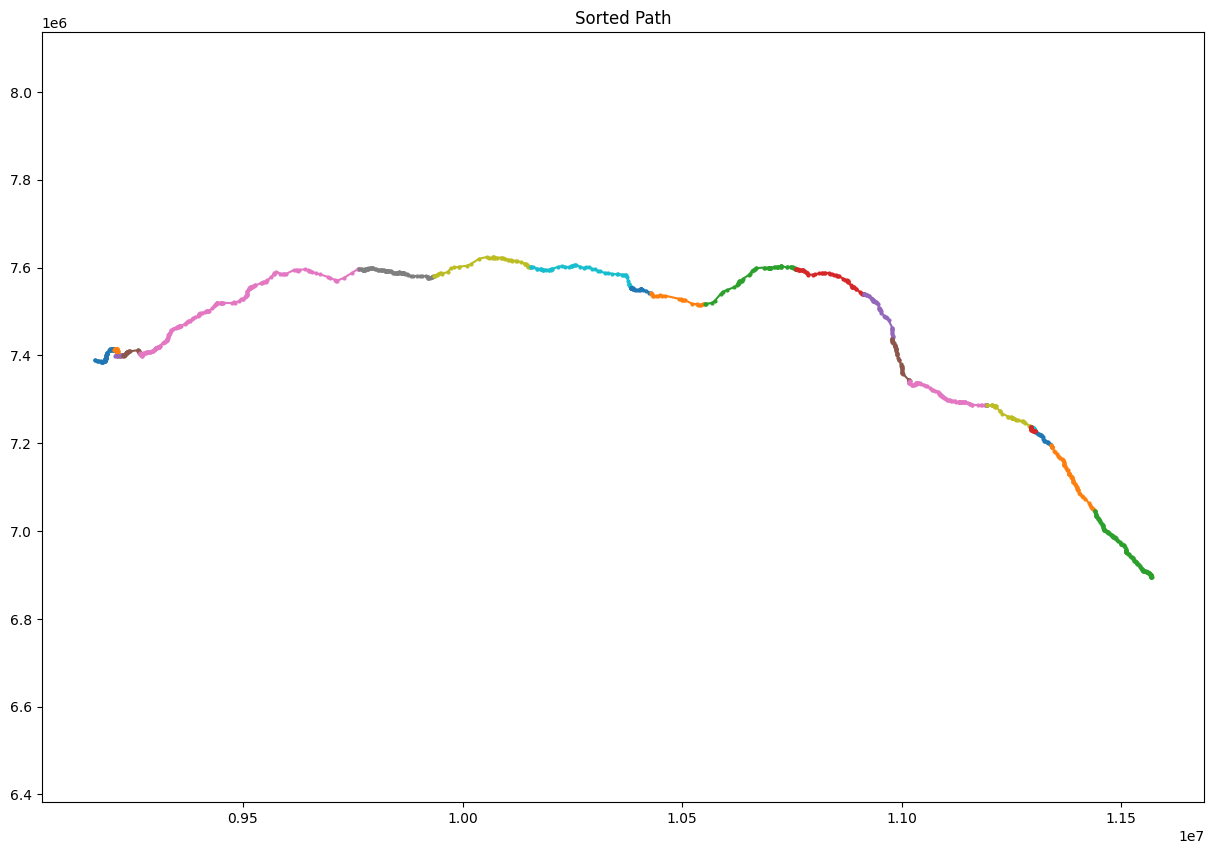

In [50]:
import matplotlib.pyplot as plt

def plot_lines(lines, color='blue', title="Sorted Lines"):
    plt.figure(figsize=(15, 10))
    for line in lines:
        x, y = zip(*line.coords)
        plt.plot(x, y, marker='o', markersize=2, linestyle='-', linewidth=1.5)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Пример использования после сортировки:
plot_lines(sorted_lines, color='red', title="Sorted Path")

Path Comparison Metrics:
hausdorff_distance: 434982.3878
average_min_distance: 180482.0435
buffer_overlap: 0.0012
path_length_ratio: 0.9569
combined_score: 0.8057


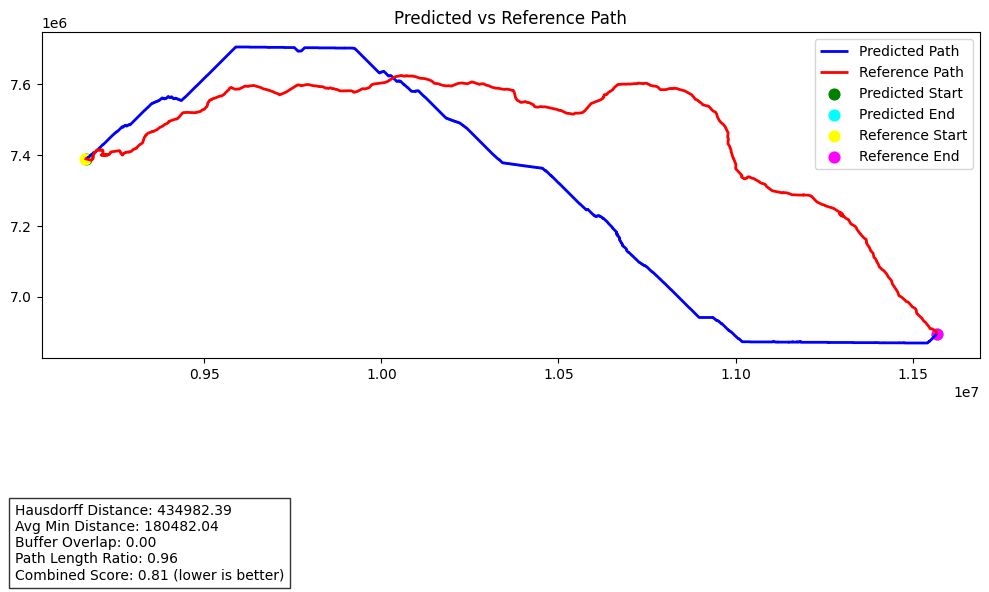

In [65]:
# Create path evaluator with reference path passed explicitly
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=result_gdf, #reference_path,  # Pass the reference path directly
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=500)  # Adjust buffer distance as needed

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=500)

# Genetic algorithm - вариант с обучением на одном изображении

In [6]:
import random
from prettytable import PrettyTable #python -m pip install prettytable

In [16]:
def fitness_function(factors, params, start_indices, end_indices, reference_path, metadata):

    cost_generator = CostMapGenerator(factors)
    weight_mapping = None
    cost_map = cost_generator.generate_cost_map(weights=params, default_weight=None, weight_mapping=weight_mapping)
    cost_map[cost_map == 0] = np.inf

    path_finder = LeastCostPathFinder(cost_map)
    path_indices, path_cost = path_finder.find_path(start_indices, end_indices, method='astar',  fully_connected=True)

    evaluator = PathEvaluator(predicted_path=path_indices, reference_path=reference_path, 
                              transform=metadata['transform'],
                              crs=metadata['crs'])
    
    metrics = evaluator.calculate_buffer_overlap(buffer_distance = 500)

    return metrics

def create_initial_population(size, lower_bound, upper_bound): # стартовые веса
    population = []
    for _ in range(size):
        

        weights = { # не прописываю protected_areas - они всегда имеют коэфф 1
            'highway': 0.6,   
            'proximity_to_cities': 1, 
            'slope': 1,
            'railways': 0.6,          
            'rivers': 0.7,        
            'wetlands': 0.7,
            'wetlands1': 0.5,
            'wetlands2': 0.9,  
        # 'highway': random.uniform(lower_bound, upper_bound),   
        # 'proximity_to_cities': random.uniform(lower_bound, upper_bound), 
        # 'slope': random.uniform(lower_bound, upper_bound),
        # 'railways': random.uniform(lower_bound, upper_bound),          
        # 'rivers': random.uniform(lower_bound, upper_bound),        
        # 'wetlands': random.uniform(lower_bound, upper_bound),
        # 'wetlands1': random.uniform(lower_bound, upper_bound),
        # 'wetlands2': random.uniform(lower_bound, upper_bound),      
        }
        individual = (weights)
        population.append(individual)

    return population

# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = {}
    child2 = {}
    
    #Проверка, что ключи совпадают
    # if parent1.keys() != parent2.keys():
    #     raise ValueError("Родители должны иметь одинаковые ключи")
    
    # Переписала через цикл, так как веса решила задавать словарем вместо массива
    for key in parent1:
        child1[key] = alpha * parent1[key] + (1 - alpha) * parent2[key]
        child2[key] = alpha * parent2[key] + (1 - alpha) * parent1[key]
    return child1, child2

# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    mutated = individual.copy()
    
    for param in mutated:
        if random.random() < mutation_rate:
            
            mutation_amount = random.uniform(-1, 1)
            mutated[param] += mutation_amount

            mutated[param] = max(min(mutated[param], upper_bound), lower_bound)


    return mutated

# Main genetic algorithm function
def genetic_algorithm(factors, population_size, lower_bound, upper_bound, generations, mutation_rate, start_indices, end_indices, reference_path, metadata):
    population = create_initial_population(population_size, lower_bound, upper_bound)

    best_performers = []
    all_populations = []
    worst_fitness = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", 'highway', 'proximity_to_cities',
                          'slope','railways','rivers','wetlands','wetlands1','wetlands2',
                          "Fitness"]

    for generation in range(generations):
        print('--- Generation {}/20 ---: '.format(generation))

        fitnesses = [fitness_function(factors, ind, start_indices, end_indices, reference_path, metadata) for ind in population]
        
        # Store the best performer of the current generation
        best_idx = np.argmax(fitnesses)
        best_fitness = max(fitnesses)
        worst_fitness = min(fitnesses)
        best_individual = population[best_idx]
        best_performers.append((best_individual, max(fitnesses)))
        all_populations.append(population[:])
        table.add_row([generation + 1,
                        best_individual['highway'], best_individual['proximity_to_cities'], 
                        best_individual['slope'], best_individual['railways'], 
                        best_individual['rivers'], best_individual['wetlands'],
                        best_individual['wetlands1'], best_individual['wetlands2'],  
                        best_fitness])
        
        print('Best fitness: {} | Avg fitness: {} | Worst fitness: {}'.format(max(fitnesses), np.mean(fitnesses), min(fitnesses)))

        population = selection(population, fitnesses)
        print('Selection performed...')

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            crossover(parent1, parent2)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))
            
        print('Created new generation via crossover and mutation...')    
        #Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    return population[np.argmax(fitnesses)], table, all_populations, best_individual, best_performers, worst_fitness

In [17]:
# Вынесла вывод после ГА в отдельную функцию
def visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness):

    print(table)

    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    # Последнее поколение значения весов фавторов
    final_population = all_populations[-1]
    
    factors_list = ['highway', 'proximity_to_cities','slope','railways','rivers','wetlands','wetlands1','wetlands2']# сожно достать и из ind
    
    axs = axs.flatten()
    for i, el in enumerate(factors_list):
        axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
        axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
        axs[i].set_title(el, fontweight='bold')
        if i==0 or i==4:
            axs[i].set_ylabel('weight', fontsize=12)
        if i>=4:
            axs[i].set_xlabel('population', fontsize=12)
    
        #axs[i].set_ylabel(el, color='blue')
        #axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Выношу легенду за пределы графика

    # for i, el in enumerate(factors_list):
    #     axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
    #     axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
    #     axs[i].set_ylabel(el, color='blue')
    #     axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Выношу легенду за пределы графика


    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Все особи'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Лучшая особь')
    ]
    fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.02),  # Размещаем над графиками
           ncol=2, fontsize=12)

    plt.tight_layout()

    fig.suptitle(f'Final Generation ({generations}) Population Solutions', fontsize=18, fontweight='bold', y=1.05)
    #axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    
   # Значения каждого параметра
    generations_list = range(1, len(best_performers) + 1)

    fig, ax = plt.subplots()
    
    colors_list = ['blue', 'green', 'red', 'purple', 'olive', 'gold', 'silver', 'indigo']
    for i, el in enumerate(factors_list):
        ax.plot(generations_list, [ind[0][el] for ind in best_performers], label=el, color=colors_list[i])

    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Значение метрики по поколениям 
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = worst_fitness
    max_fitness_values = best_fitness_values
    
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend(loc='upper left')

    plt.show()

In [3]:
dataset_path = "datasets/interest_area_500scale" # датасет, который охватывают весь путь обучающей трубы
# Используемый датасет тестовый - "datasets/vankor_1k_1k_pixel" - то на чем проверяла работу

factor_mapping = {    
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)

start_x, start_y = 9167986, 7388294
end_x, end_y = 11568914, 6894631

start_indices = data_loader.coordinates_to_indices(start_x, start_y)
end_indices = data_loader.coordinates_to_indices(end_x, end_y)

reference_path_dir = os.path.join(dataset_path, 'reference')
reference_path = load_reference_path(r'datasets\interest_area_500scale\reference\ordered_pipeline2.geojson')#reference_path_dir)
metadata = data_loader.get_common_metadata()

Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets\interest_area_500scale\reference\ordered_pipeline2.geojson


In [19]:
# Параметры ГА
population_size = 30 #100 # Должно быть четным так как шаг 2 при создании потомков
lower_bound = 0.000001
upper_bound = 1
generations = 10
mutation_rate = 0.5

# Run the genetic algorithm
best_solution, table, all_populations, best_individual, best_performers, worst_fitness = genetic_algorithm(data_loader.factors, population_size, lower_bound, upper_bound, generations, mutation_rate, start_indices, end_indices, reference_path, metadata)
print(best_solution)

--- Generation 0/20 ---: 
Best fitness: 0.00106337254380999 | Avg fitness: 0.00106337254380999 | Worst fitness: 0.00106337254380999
Selection performed...
Created new generation via crossover and mutation...
--- Generation 1/20 ---: 
Best fitness: 0.0076502628473375965 | Avg fitness: 0.001655009253615315 | Worst fitness: 0.0004050082457740399
Selection performed...
Created new generation via crossover and mutation...
--- Generation 2/20 ---: 
Best fitness: 0.0076502628473375965 | Avg fitness: 0.003325396755324342 | Worst fitness: 0.00039434047616162003
Selection performed...
Created new generation via crossover and mutation...
--- Generation 3/20 ---: 
Best fitness: 0.007914114688556939 | Avg fitness: 0.005552472134138776 | Worst fitness: 0.00039553372688837777
Selection performed...
Created new generation via crossover and mutation...
--- Generation 4/20 ---: 
Best fitness: 0.007914114688556939 | Avg fitness: 0.005729385180292516 | Worst fitness: 0.0003943673507084609
Selection perfor

In [20]:
best_solution

{'highway': 1,
 'proximity_to_cities': 0.5079463359863033,
 'slope': 0.916278284324389,
 'railways': 0.29764972048205385,
 'rivers': 0.436730044852246,
 'wetlands': 0.9447938458982073,
 'wetlands1': 0.5174310217306581,
 'wetlands2': 0.44215178967708313}

In [68]:
from prettytable import PrettyTable

weights = {
# 
# {'highway': 1,
#  'proximity_to_cities': 0.5079463359863033,
#  'slope': 0.916278284324389,
#  'railways': 0.29764972048205385,
#  'rivers': 0.436730044852246,
#  'wetlands': 0.9447938458982073,
#  'wetlands1': 0.5174310217306581,
#  'wetlands2': 0.44215178967708313}


   #'protected_areas': 1,
    'highway': 0.6,   
    'proximity_to_cities': 1, 
    'slope': 1,
    'railways': 0.6,          
    'rivers': 0.7,        
    'wetlands': 0.7,
    'wetlands1': 0.5,
    'wetlands2': 0.9,      
}

# Создаем таблицу
table = PrettyTable()

# Настраиваем столбцы
table.field_names = ["Фактор", "Вес"]
table.align["Фактор"] = "l"  # Выравнивание по левому краю
table.align["Вес"] = "r"     # Выравнивание по правому краю
table.float_format = ".1"     # Формат чисел с одним десятичным знаком

# Добавляем данные
for factor, weight in weights.items():
    table.add_row([factor, weight])

# Выводим таблицу
print(table)

+---------------------+-----+
| Фактор              | Вес |
+---------------------+-----+
| highway             | 0.6 |
| proximity_to_cities |   1 |
| slope               |   1 |
| railways            | 0.6 |
| rivers              | 0.7 |
| wetlands            | 0.7 |
| wetlands1           | 0.5 |
| wetlands2           | 0.9 |
+---------------------+-----+


{'highway': 1,
 'proximity_to_cities': 0.5079463359863033,
 'slope': 0.916278284324389,
 'railways': 0.29764972048205385,
 'rivers': 0.436730044852246,
 'wetlands': 0.9447938458982073,
 'wetlands1': 0.5174310217306581,
 'wetlands2': 0.44215178967708313}

+------------+---------+---------------------+-------------------+---------------------+-------------------+--------------------+--------------------+---------------------+-----------------------+
| Generation | highway | proximity_to_cities |       slope       |       railways      |       rivers      |      wetlands      |     wetlands1      |      wetlands2      |        Fitness        |
+------------+---------+---------------------+-------------------+---------------------+-------------------+--------------------+--------------------+---------------------+-----------------------+
|     1      |   0.6   |          1          |         1         |         0.6         |        0.7        |        0.7         |        0.5         |         0.9         |  0.00106337254380999  |
|     2      |   0.6   | 0.22710399575711127 |        1.0        |  0.5764580174899981 |         1         |        0.7         |        0.5         |  0.9000000000000001 | 0.0076502628473375965 |
|     3      | 

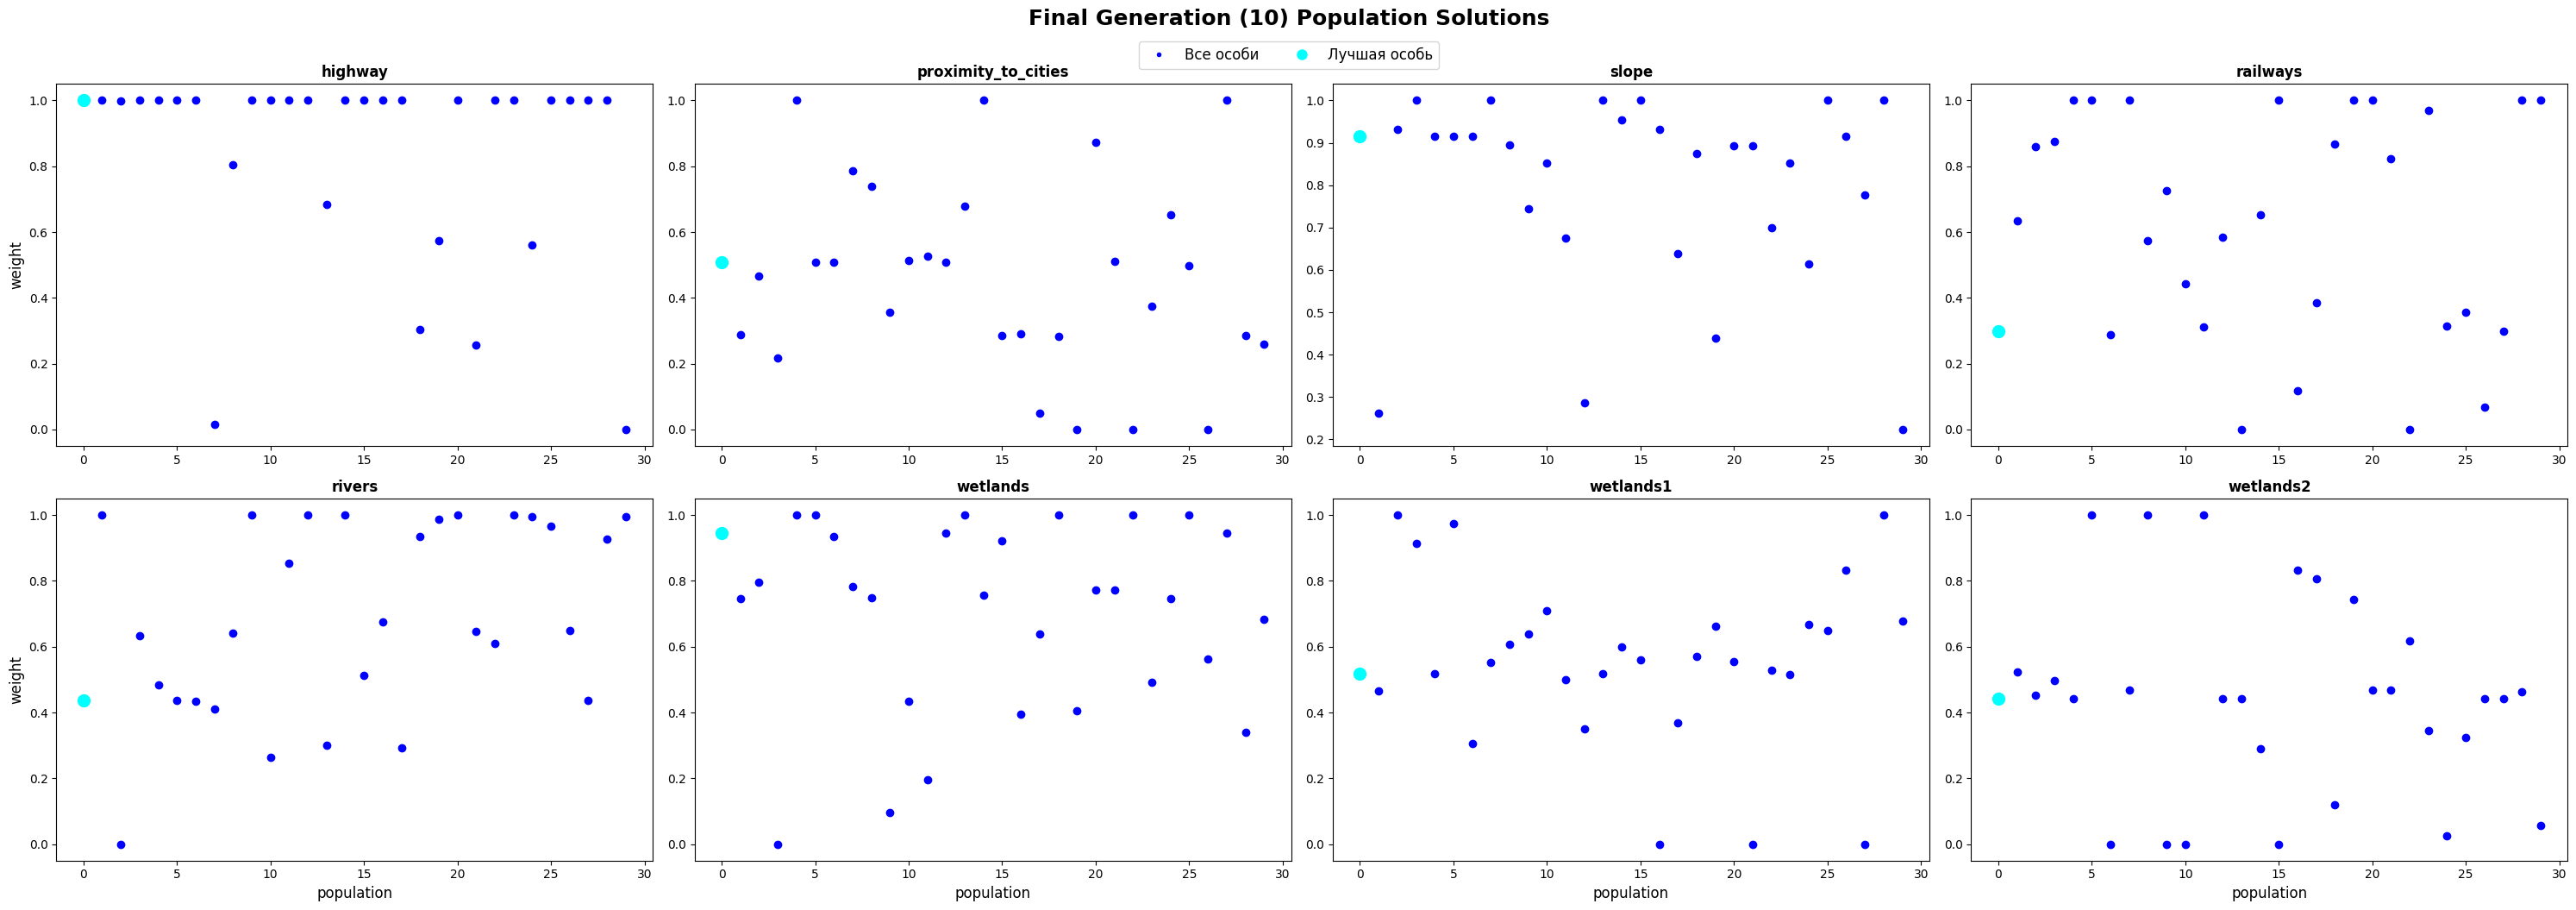

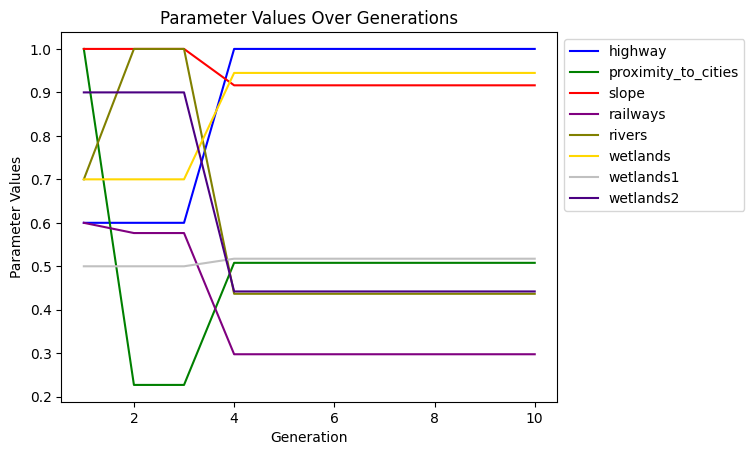

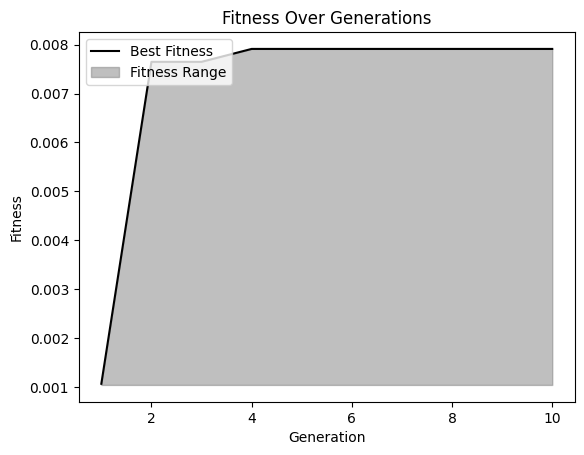

In [21]:
visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness)

Start point: (641, 11), End point: (1628, 4813)
Path found with total cost: 5404.792717633585


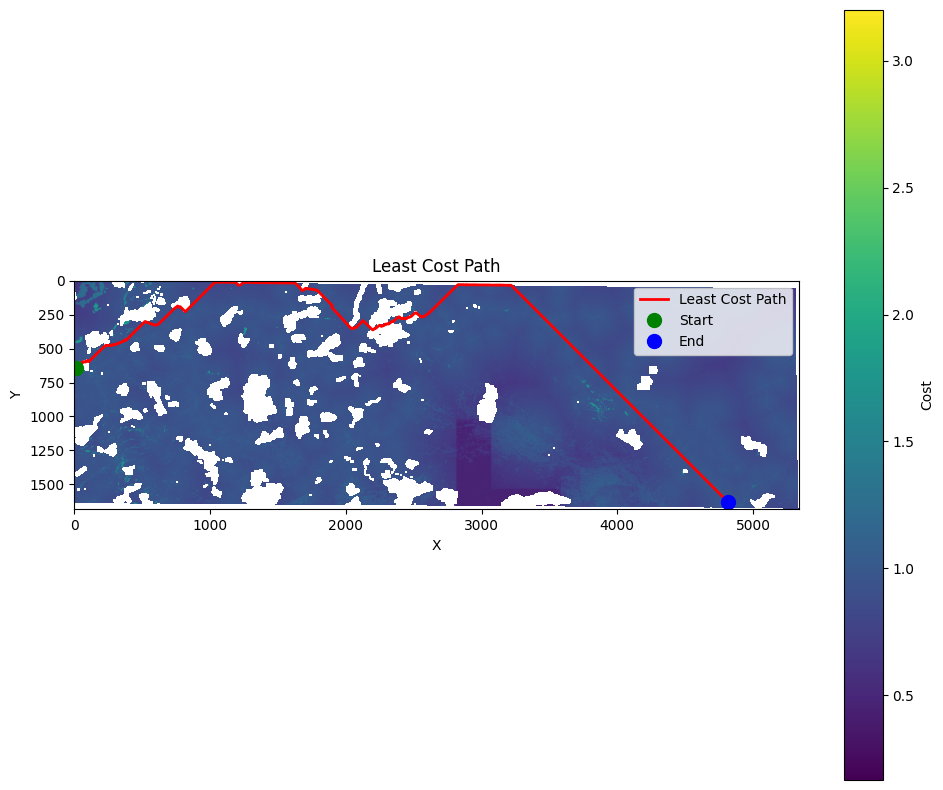

Path Comparison Metrics:
hausdorff_distance: 133011.2294
average_min_distance: 49302.1774
buffer_overlap: 0.0078
path_length_ratio: 1.0092
combined_score: 0.7921


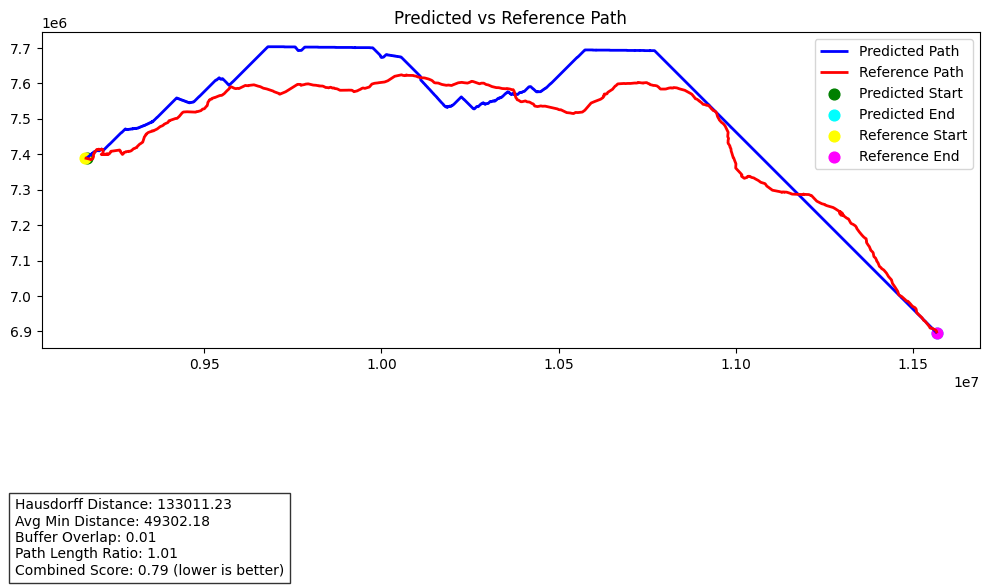

In [60]:
#vДля сравнения как оптимизировались веса (сравнение с обучающей трубой)
cost_generator = CostMapGenerator(data_loader.factors)
weight_mapping = None
cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
cost_map[cost_map == 0] = np.inf

start_x, start_y = 9167986, 7388294 
end_x, end_y = 11568914, 6894631

start_indices = data_loader.coordinates_to_indices(start_x, start_y)
end_indices = data_loader.coordinates_to_indices(end_x, end_y)

print(f"Start point: {start_indices}, End point: {end_indices}")

path_finder = LeastCostPathFinder(cost_map)
metadata = data_loader.get_common_metadata()
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  
    fully_connected=True
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path_train.geojson')
path_gdf.to_file(path_output)

evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=result_gdf, # reference_path,
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=500) # 500 * 500m  250km

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=500)

In [72]:
best_solution

{'highway': 1,
 'proximity_to_cities': 0.5079463359863033,
 'slope': 0.916278284324389,
 'railways': 0.29764972048205385,
 'rivers': 0.436730044852246,
 'wetlands': 0.9447938458982073,
 'wetlands1': 0.5174310217306581,
 'wetlands2': 0.44215178967708313}

In [73]:
start_weight = {
    'highway': 0.6,   
    'proximity_to_cities': 1, 
    'slope': 1,
    'railways': 0.6,          
    'rivers': 0.7,        
    'wetlands': 0.7,
    'wetlands1': 0.5,
    'wetlands2': 0.9,      
}

Строю для сравнения полученный вариант

Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Start point: (2188, 16192), End point: (1073, 355)
Path found with total cost: 10287.304616031113


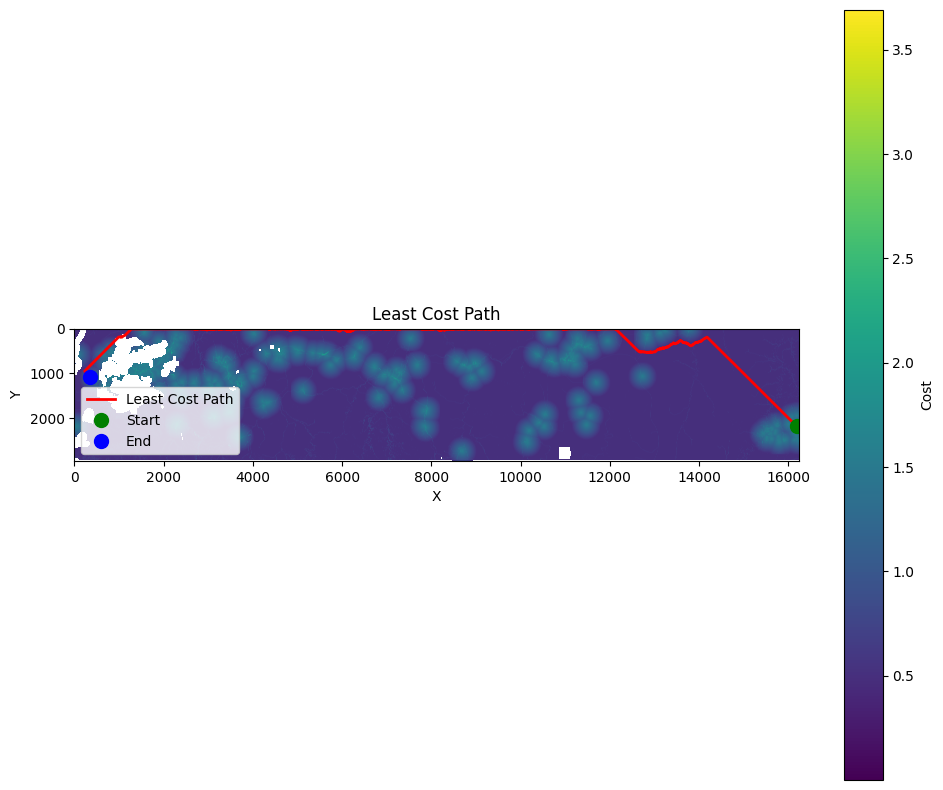

In [81]:
# Для сравнения как оптимизировались веса (сравнение с обучающей трубой)
# cost_generator = CostMapGenerator(data_loader.factors)
# weight_mapping = None
# cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
# cost_map[cost_map == 0] = np.inf

# start_x, start_y = 9167986, 7388294 # 8536880, 9502543 - для ванкора
# end_x, end_y = 11568914, 6894631 # 8563026, 9496811- для ванкора

# start_indices = data_loader.coordinates_to_indices(start_x, start_y)
# end_indices = data_loader.coordinates_to_indices(end_x, end_y)

# Построение для областей интереса от Новосибирска до Красноярска и от Жигалово до Красноярска
final_datasets = ["datasets/roi1_100scale", "datasets/roi2_100scale"]

start_x_points_list =  {"datasets/roi1_100scale": 9245443,
                        "datasets/roi2_100scale": 11813503} 

start_y_points_list = {"datasets/roi1_100scale": 7359936,
                       "datasets/roi2_100scale":7436839} 

end_x_points_list = {"datasets/roi1_100scale": 10229816,
                     "datasets/roi2_100scale":10229816} 

end_y_points_list = {"datasets/roi1_100scale": 7548399,
                     "datasets/roi2_100scale":7548399}


dataset_path = "datasets/roi2_100scale" # в качестве первого привожу от новосибирска до красноярска

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)
start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
#reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

cost_generator = CostMapGenerator(data_loader.factors)
weight_mapping = None
cost_map = cost_generator.generate_cost_map(weights=start_weight, default_weight=None, weight_mapping=weight_mapping)#best_solution
cost_map[cost_map == 0] = np.inf

print(f"Start point: {start_indices}, End point: {end_indices}")

path_finder = LeastCostPathFinder(cost_map)
metadata = data_loader.get_common_metadata()
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  
    fully_connected=True
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path_roi2_start.geojson')
path_gdf.to_file(path_output)

In [75]:
# evaluator = PathEvaluator(
#     predicted_path=path_indices,
#     reference_path=reference_path,
#     transform=metadata['transform'],
#     crs=metadata['crs']
# )

# # Calculate all metrics
# metrics = evaluator.evaluate_all_metrics(buffer_distance=100) # 3 км

# # Display metrics
# print("Path Comparison Metrics:")
# for metric_name, value in metrics.items():
#     print(f"{metric_name}: {value:.4f}")

# # Visualize paths with metrics
# evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

# Genetic algorithm - вариант с обучением на нескольких изображениях

In [ ]:
# Датасет областей для обучения и точки начала и конца существующей трубы 
dataset_path_list = ["datasets/roi1_600k_300k_meters", "datasets/roi2_600k_300k_meters", "datasets/roi3_600k_300k_meters", "datasets/roi4_600k_300k_meters"] #["datasets/vankor_1k_1k_pixel", "datasets/vankor_1k_1k_pixel2"]
# data_loader_list = {} # словарь с data_loaders, где ключ путь к датасету
start_x_points_list =  {"datasets/roi1_600k_300k_meters": 9187144,
 "datasets/roi2_600k_300k_meters": 9779945,
 "datasets/roi3_600k_300k_meters":10388398,
 "datasets/roi4_600k_300k_meters":11000302} #{"datasets/vankor_1k_1k_pixel": 8536880, "datasets/vankor_1k_1k_pixel2": 8536880}

start_y_points_list = {"datasets/roi1_600k_300k_meters": 7397263,
 "datasets/roi2_600k_300k_meters":7596219,
 "datasets/roi3_600k_300k_meters":7551750,
 "datasets/roi4_600k_300k_meters":7364953} #{"datasets/vankor_1k_1k_pixel": 9502543, "datasets/vankor_1k_1k_pixel2": 9502543}

end_x_points_list = {"datasets/roi1_600k_300k_meters": 9767670,
 "datasets/roi2_600k_300k_meters":10378861,
 "datasets/roi3_600k_300k_meters":10987319,
 "datasets/roi4_600k_300k_meters":11418279} #{"datasets/vankor_1k_1k_pixel": 8563026, "datasets/vankor_1k_1k_pixel2": 8563026}

end_y_points_list = {"datasets/roi1_600k_300k_meters": 7597333,
 "datasets/roi2_600k_300k_meters":7561722,
 "datasets/roi3_600k_300k_meters":7409062,
 "datasets/roi4_600k_300k_meters":7073188} #{"datasets/vankor_1k_1k_pixel": 9496811, "datasets/vankor_1k_1k_pixel2": 9496811}

# reference_path_list = {}

factor_mapping = {
    'protectedMask.tif': 'protected_areas',
    'inverted_urban_zones.tif': 'proximity_to_cities',
    'slopeSuitability.tif': 'slope',
    'railwayMask.tif': 'railways',
    'riversMask.tif': 'rivers',
    'wetlandMask.tif': 'wetlands',
    'wetland1Mask.tif': 'wetlands1',
    'wetland2Mask.tif': 'wetlands2',
    'highwayMask.tif': 'highway',
}

# for dataset_path in dataset_path_list: # Паталась использовать подход, чтобы сразу несколько data_loaders хранилиссь в списвке, но из-за проблем с памятью, перешла к ваарианту, 
# когда на каждой итерации поколения считываются изображение - внутри ГА

#     data_loader_list[dataset_path] = DataLoader(dataset_path)
#     data_loader_list[dataset_path].load_data(factor_mapping=factor_mapping)
#     reference_path_list[dataset_path] =  load_reference_path(os.path.join(dataset_path, 'reference'))


In [4]:
import random
from prettytable import PrettyTable #python -m pip install prettytable

In [ ]:
def fitness_function(factors, params, start_indices, end_indices, reference_path, metadata):

    cost_generator = CostMapGenerator(factors)
    weight_mapping = None
    cost_map = cost_generator.generate_cost_map(weights=params, default_weight=None, weight_mapping=weight_mapping)
    cost_map[cost_map == 0] = np.inf

    path_finder = LeastCostPathFinder(cost_map)
    path_indices, path_cost = path_finder.find_path(start_indices, end_indices, method='astar',  fully_connected=True)

    evaluator = PathEvaluator(predicted_path=path_indices, reference_path=reference_path, 
                              transform=metadata['transform'],
                              crs=metadata['crs'])
    
    metrics = evaluator.calculate_buffer_overlap(buffer_distance = 100)

    return metrics

def create_initial_population(size, lower_bound, upper_bound): # стартовые веса
    population = []
    for _ in range(size):

        weights = { # не прописываю protected_areas - они всегда имеют коэфф 1
            'highway': 0.6,   
            'proximity_to_cities': 1, 
            'slope': 1,
            'railways': 0.6,          
            'rivers': 0.7,        
            'wetlands': 0.7,
            'wetlands1': 0.5,
            'wetlands2': 0.9,        
        }
        individual = (weights)
        population.append(individual)

    return population

# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = {}
    child2 = {}

    # Переписала через цикл, так как веса решила задавать словарем вместо массива
    for key in parent1:
        child1[key] = alpha * parent1[key] + (1 - alpha) * parent2[key]
        child2[key] = alpha * parent2[key] + (1 - alpha) * parent1[key]
    return child1, child2

# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    mutated = individual.copy()
    
    for param in mutated:
        if random.random() < mutation_rate:
            
            mutation_amount = random.uniform(-1, 1)
            mutated[param] += mutation_amount

            mutated[param] = max(min(mutated[param], upper_bound), lower_bound)


    return mutated

# Main genetic algorithm function
def genetic_algorithm(dataset_path_list, factor_mapping, population_size, lower_bound, upper_bound, generations, mutation_rate,
                      start_x_points_list, start_y_points_list, end_x_points_list, end_y_points_list):
    population = create_initial_population(population_size, lower_bound, upper_bound)

    best_performers = []
    all_populations = []
    worst_fitness = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", 'highway', 'proximity_to_cities',
                          'slope','railways','rivers','wetlands','wetlands1','wetlands2',
                          "Fitness"]

    for generation in range(generations):
        print('Generation №: ', generation)
        
        # Часть, где чередуется каждое поколение область для обучения
        dataset_path = dataset_path_list[generation % len(dataset_path_list)]
        print('dataset_path: ', dataset_path)
        data_loader = DataLoader(dataset_path)
        data_loader.load_data(factor_mapping=factor_mapping)
        factors =  data_loader.factors
        start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
        end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
        reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))
        metadata = data_loader.get_common_metadata()

        fitnesses = [fitness_function(factors, ind, start_indices, end_indices, reference_path, metadata) for ind in population]
        
        # Store the best performer of the current generation
        best_idx = np.argmax(fitnesses)
        best_fitness = max(fitnesses)
        worst_fitness = min(fitnesses)
        best_individual = population[best_idx]
        best_performers.append((best_individual, max(fitnesses)))
        all_populations.append(population[:])
        table.add_row([generation + 1,
                        best_individual['highway'], best_individual['proximity_to_cities'], 
                        best_individual['slope'], best_individual['railways'], 
                        best_individual['rivers'], best_individual['wetlands'],
                        best_individual['wetlands1'], best_individual['wetlands2'],  
                        best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            crossover(parent1, parent2)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

            
        #Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    return population[np.argmax(fitnesses)], table, all_populations, best_individual, best_performers, worst_fitness

In [ ]:
# Вынесла вывод после ГА в отдельную функцию
def visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness):

    print(table)

    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    # Последнее поколение значения весов фавторов
    final_population = all_populations[-1]
    
    factors_list = ['highway', 'proximity_to_cities','slope','railways','rivers','wetlands','wetlands1','wetlands2']# можно достать и из ind
    
    axs = axs.flatten()
    for i, el in enumerate(factors_list):
        axs[i].scatter(range(len(final_population)), [ind[el] for ind in final_population], color='blue', label=el)
        axs[i].scatter([final_population.index(best_individual)], [best_individual[el]], color='cyan', s=100, label='Best Individual {}'.format(el))
        axs[i].set_title(el, fontweight='bold')
        if i==0 or i==4:
            axs[i].set_ylabel('weight', fontsize=12)
        if i>=4:
            axs[i].set_xlabel('population', fontsize=12)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Все особи'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Лучшая особь')
    ]
    fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.02),  # Размещаем над графиками
           ncol=2, fontsize=12)

    plt.tight_layout()

    fig.suptitle(f'Final Generation ({generations}) Population Solutions', fontsize=18, fontweight='bold', y=1.05)

    
   # Значения каждого параметра
    generations_list = range(1, len(best_performers) + 1)

    fig, ax = plt.subplots()
    
    colors_list = ['blue', 'green', 'red', 'purple', 'olive', 'gold', 'silver', 'indigo']
    for i, el in enumerate(factors_list):
        ax.plot(generations_list, [ind[0][el] for ind in best_performers], label=el, color=colors_list[i])

    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

    # Значение метрики по поколениям 
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = worst_fitness
    max_fitness_values = best_fitness_values
    
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend(loc='upper left')

    plt.show()

In [ ]:
# Parameters for the genetic algorithm
population_size = 100 # Должно быть четным так как шаг 2 при создании потомков
lower_bound = 0.000001
upper_bound = 1
generations = 5
mutation_rate = 1


# Run the genetic algorithm
best_solution, table, all_populations, best_individual, best_performers, worst_fitness = genetic_algorithm(dataset_path_list, factor_mapping, population_size, lower_bound, upper_bound, generations, mutation_rate, start_x_points_list, start_y_points_list, end_x_points_list, end_y_points_list)
print(best_solution)

Generation №:  0
dataset_path:  datasets/vankor_1k_1k_pixel
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson
Generation №:  1
dataset_path:  datasets/vankor_1k_1k_pixel2
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel2\reference\pipe.geojson
Generation №:  2
dataset_path:  datasets/vankor_1k_1k_pixel
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 'railways', 'rivers', 'slope', 'wetlands1', 'wetlands2', 'wetlands']
Loaded reference path from datasets/vankor_1k_1k_pixel\reference\pipe.geojson
Generation №:  3
dataset_path:  datasets/vankor_1k_1k_pixel2
Loaded 9 raster factors: ['highway', 'proximity_to_cities', 'protected_areas', 

+------------+---------+---------------------+-------+--------------------+--------------------+----------+-----------+-----------+----------------------+
| Generation | highway | proximity_to_cities | slope |      railways      |       rivers       | wetlands | wetlands1 | wetlands2 |       Fitness        |
+------------+---------+---------------------+-------+--------------------+--------------------+----------+-----------+-----------+----------------------+
|     1      |   0.6   |          1          |   1   |        0.6         |        0.7         |   0.7    |    0.5    |    0.9    | 0.004988007634337018 |
|     2      |    1    |  0.4042218030948548 |   1   | 0.6528417926289295 | 0.6682447448709636 |    1     |     1     |     1     | 0.05714668948561461  |
|     3      |    1    |  0.4042218030948548 |   1   | 0.6528417926289295 | 0.6682447448709636 |    1     |     1     |     1     | 0.05714668948561461  |
|     4      |    1    |  0.4042218030948548 |   1   | 0.6528417926289

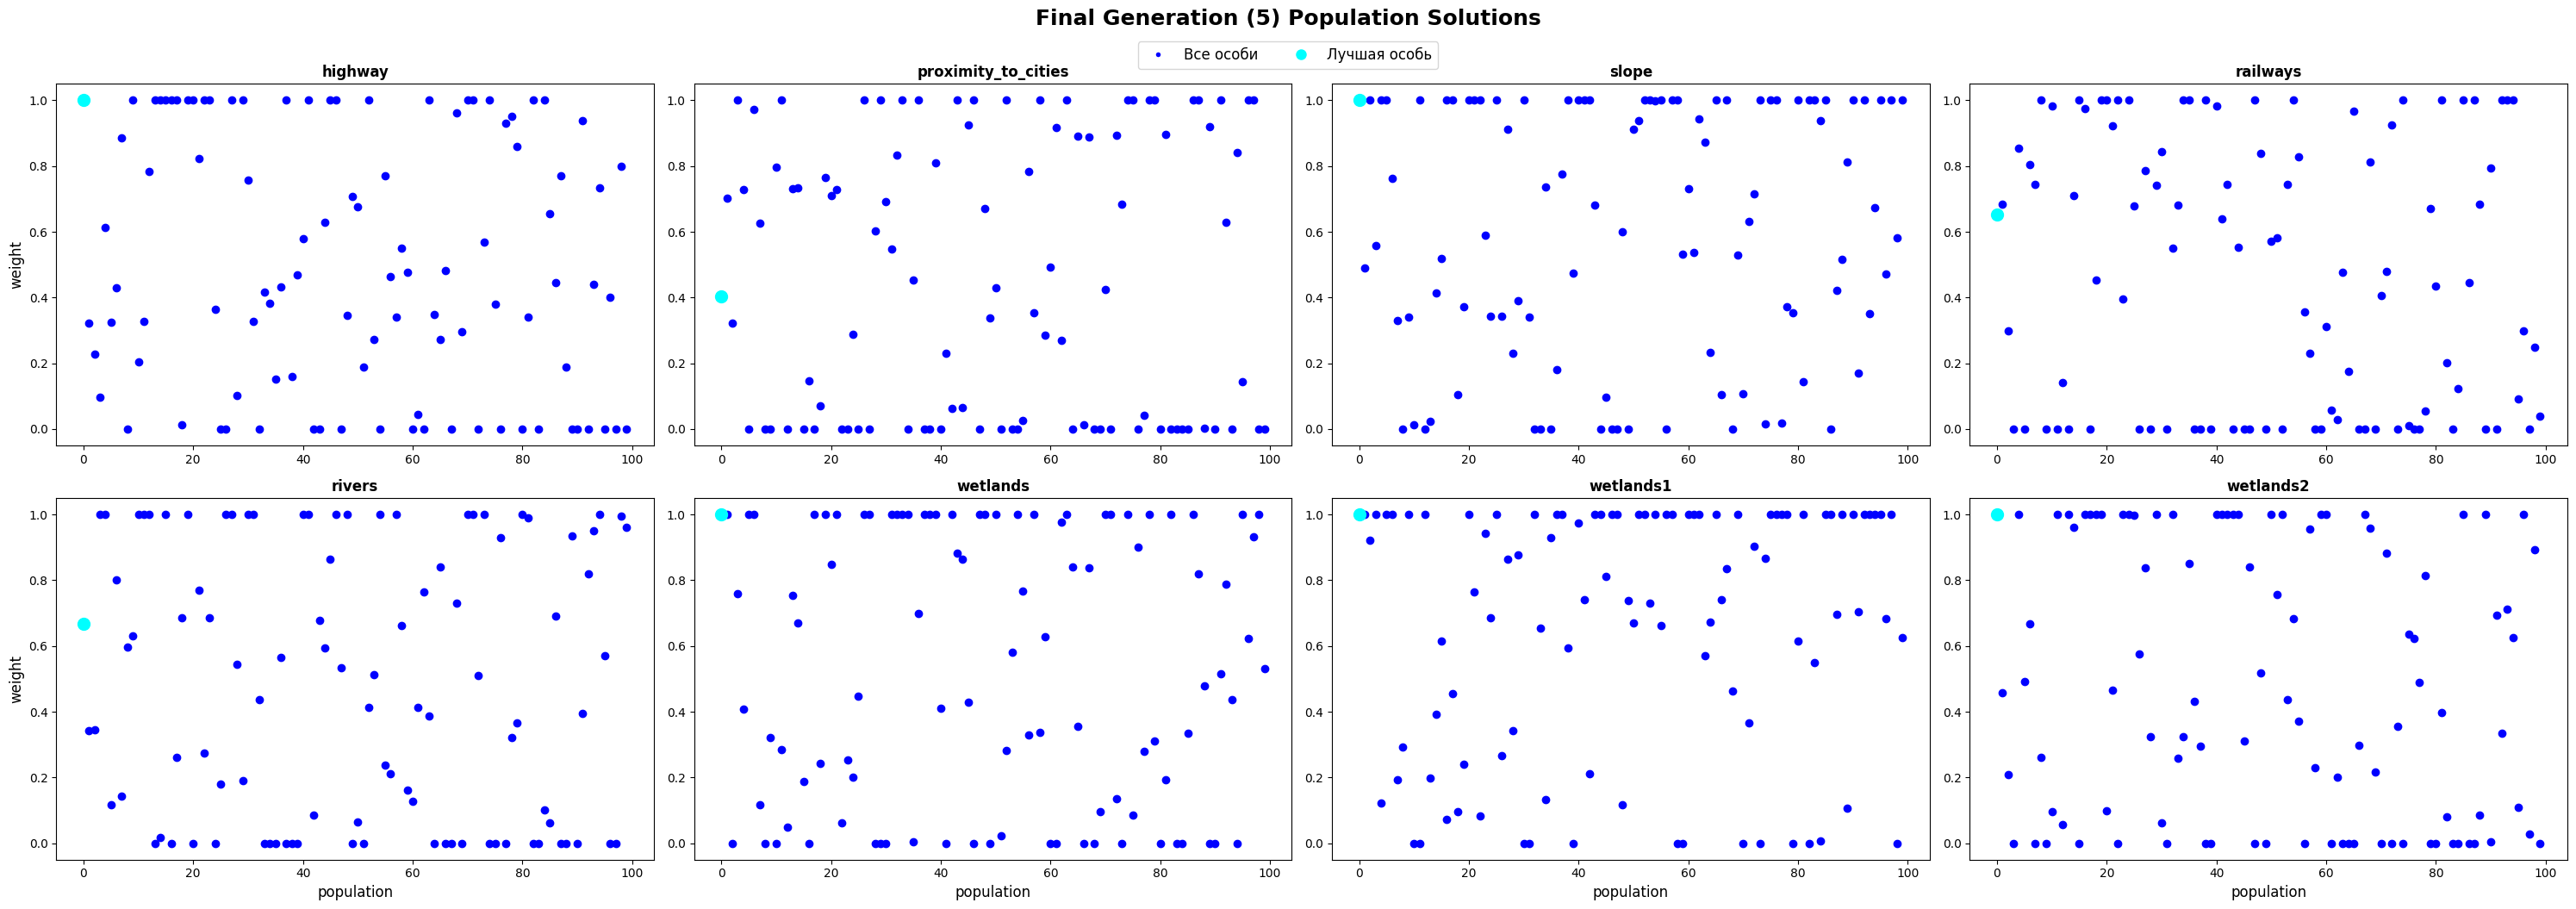

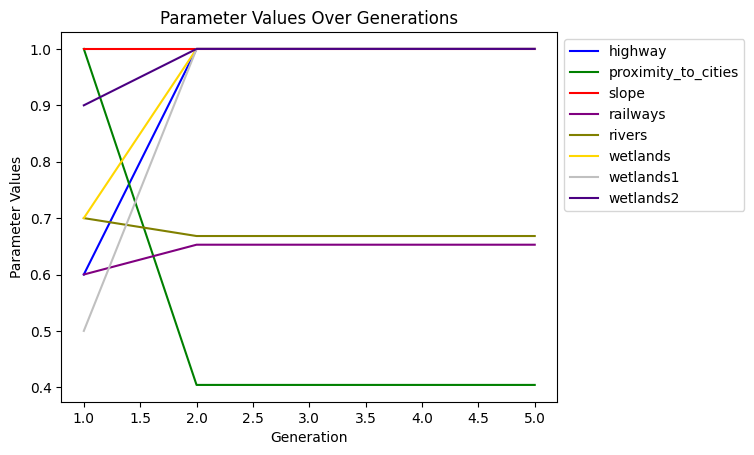

In [ ]:
visualize_ga_results(table, all_populations, best_individual, generations, best_performers, worst_fitness)

In [ ]:
# Для построения финального пути с новыми коэффициентами - вариант, если сравнивать поданный маршрут и построенный
# dataset_path = "datasets/roi1_600k_300k_meters"
# data_loader = DataLoader(dataset_path)
# data_loader.load_data(factor_mapping=factor_mapping)
# start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
# end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
# reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

# Построение для областей интереса от Новосибирска до Красноярска и от Жигалово до Красноярска
final_datasets = ["datasets/roi1", "datasets/roi2"]

start_x_points_list =  {"datasets/roi1": 9245443,
                        "datasets/roi2": 11813503} 

start_y_points_list = {"datasets/roi1": 7359936,
                       "datasets/roi2":7436839} 

end_x_points_list = {"datasets/roi1": 10229816,
                     "datasets/roi2":10229816} 

end_y_points_list = {"datasets/roi1": 7548399,
                     "datasets/roi2":7548399}


dataset_path = "datasets/roi1" # в качестве первого привожу от новосибирска до красноярска

data_loader = DataLoader(dataset_path)
data_loader.load_data(factor_mapping=factor_mapping)
start_indices = data_loader.coordinates_to_indices(start_x_points_list[dataset_path], start_y_points_list[dataset_path])
end_indices = data_loader.coordinates_to_indices(end_x_points_list[dataset_path], end_y_points_list[dataset_path])
reference_path = load_reference_path(os.path.join(dataset_path, 'reference'))

cost_generator = CostMapGenerator(data_loader.factors)
weight_mapping = None
cost_map = cost_generator.generate_cost_map(weights=best_solution, default_weight=None, weight_mapping=weight_mapping)
cost_map[cost_map == 0] = np.inf

print(f"Start point: {start_indices}, End point: {end_indices}")

path_finder = LeastCostPathFinder(cost_map)
metadata = data_loader.get_common_metadata()
path_indices, path_cost = path_finder.find_path(
    start_indices, 
    end_indices, 
    method='astar',  
    fully_connected=True 
)
print(f"Path found with total cost: {path_cost}")

# Visualize path on cost map
path_finder.visualize_path(path_indices, start_indices, end_indices)

# Convert path to GeoDataFrame (pass transform and crs here)
path_gdf = path_finder.path_to_geodataframe(
    path_indices, 
    path_cost, 
    transform=metadata['transform'], 
    crs=metadata['crs']
)

# Save path (optional)
path_output = os.path.join(dataset_path, 'results', 'least_cost_path.geojson')
path_gdf.to_file(path_output)

In [ ]:
evaluator = PathEvaluator(
    predicted_path=path_indices,
    reference_path=reference_path,
    transform=metadata['transform'],
    crs=metadata['crs']
)

# Calculate all metrics
metrics = evaluator.evaluate_all_metrics(buffer_distance=100) # 3 км

# Display metrics
print("Path Comparison Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize paths with metrics
evaluator.visualize_paths(title="Predicted vs Reference Path", buffer_distance=100)

# Объединение нескольких растров в один

In [18]:
# datasets/interest_area
tile_paths1 =['datasets/interest_area/factors/slopeSuitability-0000000000-0000000000.tif',
             'datasets/interest_area/factors/slopeSuitability-0000000000-0000065536.tif'] # перечислить файлы, которые надо объединить
output_path1 = 'datasets/interest_area/factors/slopeSuitability.tif'

tile_paths2 =['datasets/interest_area/factors/highwayMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/highwayMask-0000000000-0000065536.tif'] 
output_path2 = 'datasets/interest_area/factors/highwayMask.tif'

tile_paths3 =['datasets/interest_area/factors/riversMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/riversMask-0000000000-0000065536.tif'] 
output_path3 = 'datasets/interest_area/factors/riversMask.tif'

tile_paths4 =['datasets/interest_area/factors/railwayMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/railwayMask-0000000000-0000065536.tif'] 
output_path4 = 'datasets/interest_area/factors/railwayMask.tif'

tile_paths5 =['datasets/interest_area/factors/wetlandMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetlandMask-0000000000-0000065536.tif'] 
output_path5 = 'datasets/interest_area/factors/wetlandMask.tif'

tile_paths6 =['datasets/interest_area/factors/wetland1Mask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetland1Mask-0000000000-0000065536.tif'] 
output_path6 = 'datasets/interest_area/factors/wetland1Mask.tif'

tile_paths7 =['datasets/interest_area/factors/wetland2Mask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/wetland2Mask-0000000000-0000065536.tif'] 
output_path7 = 'datasets/interest_area/factors/wetland2Mask.tif'

tile_paths8 =['datasets/interest_area/factors/inverted_urban_zones-0000000000-0000000000.tif',
             'datasets/interest_area/factors/inverted_urban_zones-0000000000-0000065536.tif'] 
output_path8 = 'datasets/interest_area/factors/inverted_urban_zones.tif'

tile_paths9 =['datasets/interest_area/factors/protectedMask-0000000000-0000000000.tif',
             'datasets/interest_area/factors/protectedMask-0000000000-0000065536.tif'] 
output_path9 = 'datasets/interest_area/factors/protectedMask.tif'

In [19]:
import rasterio
from rasterio.merge import merge

In [ ]:
# Открываю все тайлы и сохраняю в список
src_files = [rasterio.open(fp) for fp in tile_paths1]

# Объединяю тайлы
mosaic, out_transform = merge(src_files)

# Закрываю все исходные файлы
for src in src_files:
    src.close()

print("Форма объединенного растра:", mosaic.shape)

with rasterio.open(tile_paths1[0]) as src:
    meta = src.meta.copy()

# Обновляю метаданные для mosaic
meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'count': mosaic.shape[0],  # Количество каналов
    'dtype': mosaic.dtype
})

# Сохраняю в файл
output_path = output_path1
with rasterio.open(output_path, 'w', compress='lzw', **meta) as dst:
    dst.write(mosaic)